In [1]:
pip install tensorflow matplotlib pandas tqdm pydot graphviz


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-08-04 17:53:10.198190: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
image_size = (180, 180)
batch_size = 32

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=48,
    image_size=image_size,
    batch_size=batch_size
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


2023-08-04 17:53:15.564972: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10216 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:06:00.0, compute capability: 8.6


In [4]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1)
    ]
)

In [5]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [6]:
def make_base_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape)
    
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    previous_block_activation = x
    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        
        x = layers.add([x, residual])
        previous_block_activation = x
        
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [7]:
model = make_base_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [8]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [9]:
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds
)

Epoch 1/25


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
2023-08-04 17:53:24.794617: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-04 17:53:27.486053: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-04 17:53:27.486656: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1e143c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-04 17:53:27.486696: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-08-04 17:53:27.495235: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-04 17:53:27.683852: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  Thi

 71/586 [==>...........................] - ETA: 1:24 - loss: 0.7311 - accuracy: 0.5735

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


122/586 [=====>........................] - ETA: 1:16 - loss: 0.7177 - accuracy: 0.5871

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


234/586 [==========>...................] - ETA: 57s - loss: 0.6970 - accuracy: 0.5980

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


266/586 [============>.................] - ETA: 52s - loss: 0.6949 - accuracy: 0.6004

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


277/586 [=============>................] - ETA: 50s - loss: 0.6927 - accuracy: 0.6016

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


311/586 [==============>...............] - ETA: 45s - loss: 0.6874 - accuracy: 0.6074

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


338/586 [================>.............] - ETA: 40s - loss: 0.6840 - accuracy: 0.6106

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


340/586 [================>.............] - ETA: 40s - loss: 0.6840 - accuracy: 0.6106

525/586 [=========================>....] - ETA: 10s - loss: 0.6589 - accuracy: 0.6340

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.6549 - accuracy: 0.6374

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 128s 184ms/step - loss: 0.6549 - accuracy: 0.6374 - val_loss: 0.6898 - val_accuracy: 0.5733
Epoch 2/25
  3/586 [..............................] - ETA: 2:26 - loss: 0.5789 - accuracy: 0.6667

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:27 - loss: 0.5977 - accuracy: 0.6946

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:17 - loss: 0.5873 - accuracy: 0.6994

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 58s - loss: 0.5693 - accuracy: 0.7127

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 52s - loss: 0.5659 - accuracy: 0.7155

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 50s - loss: 0.5635 - accuracy: 0.7169

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 45s - loss: 0.5617 - accuracy: 0.7181

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 40s - loss: 0.5578 - accuracy: 0.7213

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 40s - loss: 0.5574 - accuracy: 0.7216

529/586 [==========================>...] - ETA: 9s - loss: 0.5322 - accuracy: 0.7375

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.5269 - accuracy: 0.7407

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 106s 179ms/step - loss: 0.5269 - accuracy: 0.7407 - val_loss: 0.5498 - val_accuracy: 0.7345
Epoch 3/25
  2/586 [..............................] - ETA: 2:17 - loss: 0.4923 - accuracy: 0.7656 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:28 - loss: 0.4759 - accuracy: 0.7817

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:18 - loss: 0.4656 - accuracy: 0.7810

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 58s - loss: 0.4660 - accuracy: 0.7806

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 52s - loss: 0.4647 - accuracy: 0.7817

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 50s - loss: 0.4638 - accuracy: 0.7817

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 45s - loss: 0.4594 - accuracy: 0.7850

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 40s - loss: 0.4576 - accuracy: 0.7854

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 40s - loss: 0.4569 - accuracy: 0.7856

529/586 [==========================>...] - ETA: 9s - loss: 0.4438 - accuracy: 0.7943

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.4385 - accuracy: 0.7976

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 106s 179ms/step - loss: 0.4384 - accuracy: 0.7976 - val_loss: 0.3787 - val_accuracy: 0.8375
Epoch 4/25
  3/586 [..............................] - ETA: 1:55 - loss: 0.2927 - accuracy: 0.9062

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:27 - loss: 0.3848 - accuracy: 0.8267

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:17 - loss: 0.3798 - accuracy: 0.8321

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 58s - loss: 0.3845 - accuracy: 0.8301

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 52s - loss: 0.3815 - accuracy: 0.8326

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 50s - loss: 0.3807 - accuracy: 0.8333

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 45s - loss: 0.3786 - accuracy: 0.8342

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 40s - loss: 0.3775 - accuracy: 0.8350

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 40s - loss: 0.3772 - accuracy: 0.8352

529/586 [==========================>...] - ETA: 9s - loss: 0.3639 - accuracy: 0.8404

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.3629 - accuracy: 0.8408

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 106s 179ms/step - loss: 0.3628 - accuracy: 0.8408 - val_loss: 0.3249 - val_accuracy: 0.8654
Epoch 5/25
  3/586 [..............................] - ETA: 1:59 - loss: 0.3431 - accuracy: 0.8750

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:27 - loss: 0.3338 - accuracy: 0.8512

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:17 - loss: 0.3443 - accuracy: 0.8480

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 58s - loss: 0.3330 - accuracy: 0.8570

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 52s - loss: 0.3308 - accuracy: 0.8590

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 50s - loss: 0.3296 - accuracy: 0.8597

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 45s - loss: 0.3295 - accuracy: 0.8604

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 40s - loss: 0.3296 - accuracy: 0.8606

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 40s - loss: 0.3287 - accuracy: 0.8609

529/586 [==========================>...] - ETA: 9s - loss: 0.3175 - accuracy: 0.8644

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.3126 - accuracy: 0.8660

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 106s 179ms/step - loss: 0.3127 - accuracy: 0.8660 - val_loss: 0.3919 - val_accuracy: 0.8093
Epoch 6/25
  4/586 [..............................] - ETA: 2:14 - loss: 0.3003 - accuracy: 0.8594

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:27 - loss: 0.2712 - accuracy: 0.8867

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:17 - loss: 0.2826 - accuracy: 0.8854

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 58s - loss: 0.2821 - accuracy: 0.8812

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 52s - loss: 0.2792 - accuracy: 0.8829

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 50s - loss: 0.2788 - accuracy: 0.8833

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 45s - loss: 0.2756 - accuracy: 0.8847

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 40s - loss: 0.2751 - accuracy: 0.8851

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 40s - loss: 0.2746 - accuracy: 0.8855

529/586 [==========================>...] - ETA: 9s - loss: 0.2660 - accuracy: 0.8888

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.2631 - accuracy: 0.8899

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 106s 179ms/step - loss: 0.2631 - accuracy: 0.8898 - val_loss: 0.3162 - val_accuracy: 0.8695
Epoch 7/25
  3/586 [..............................] - ETA: 1:59 - loss: 0.2680 - accuracy: 0.8646

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:28 - loss: 0.2383 - accuracy: 0.8967

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:18 - loss: 0.2469 - accuracy: 0.8931

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 58s - loss: 0.2506 - accuracy: 0.8935

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 52s - loss: 0.2497 - accuracy: 0.8934

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 51s - loss: 0.2512 - accuracy: 0.8927

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 45s - loss: 0.2502 - accuracy: 0.8931

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 40s - loss: 0.2496 - accuracy: 0.8934

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 40s - loss: 0.2496 - accuracy: 0.8934

529/586 [==========================>...] - ETA: 9s - loss: 0.2403 - accuracy: 0.8972

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.2375 - accuracy: 0.8979

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 106s 179ms/step - loss: 0.2375 - accuracy: 0.8980 - val_loss: 0.2558 - val_accuracy: 0.8941
Epoch 8/25
  4/586 [..............................] - ETA: 1:54 - loss: 0.2400 - accuracy: 0.9219

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:28 - loss: 0.2219 - accuracy: 0.9096

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:17 - loss: 0.2171 - accuracy: 0.9070

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 58s - loss: 0.2265 - accuracy: 0.9077

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 52s - loss: 0.2278 - accuracy: 0.9069

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 50s - loss: 0.2272 - accuracy: 0.9074

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 45s - loss: 0.2236 - accuracy: 0.9100

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 40s - loss: 0.2233 - accuracy: 0.9094

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 40s - loss: 0.2234 - accuracy: 0.9094

529/586 [==========================>...] - ETA: 9s - loss: 0.2162 - accuracy: 0.9108

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.2150 - accuracy: 0.9105

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 106s 179ms/step - loss: 0.2150 - accuracy: 0.9105 - val_loss: 0.2364 - val_accuracy: 0.8971
Epoch 9/25
  4/586 [..............................] - ETA: 2:11 - loss: 0.2637 - accuracy: 0.8750

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:28 - loss: 0.2066 - accuracy: 0.9083

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:17 - loss: 0.2127 - accuracy: 0.9060

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 58s - loss: 0.2080 - accuracy: 0.9112

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 52s - loss: 0.2067 - accuracy: 0.9131

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 50s - loss: 0.2060 - accuracy: 0.9130

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 45s - loss: 0.2042 - accuracy: 0.9132

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 40s - loss: 0.2046 - accuracy: 0.9144

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 40s - loss: 0.2041 - accuracy: 0.9145

529/586 [==========================>...] - ETA: 9s - loss: 0.1988 - accuracy: 0.9176

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1962 - accuracy: 0.9188

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 106s 179ms/step - loss: 0.1963 - accuracy: 0.9188 - val_loss: 0.2926 - val_accuracy: 0.8802
Epoch 10/25
  4/586 [..............................] - ETA: 1:52 - loss: 0.1802 - accuracy: 0.9297

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:27 - loss: 0.1907 - accuracy: 0.9217

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:17 - loss: 0.1995 - accuracy: 0.9199

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 58s - loss: 0.1932 - accuracy: 0.9228

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 52s - loss: 0.1938 - accuracy: 0.9211

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 50s - loss: 0.1929 - accuracy: 0.9207

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 45s - loss: 0.1912 - accuracy: 0.9207

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 40s - loss: 0.1906 - accuracy: 0.9206

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 40s - loss: 0.1902 - accuracy: 0.9207

529/586 [==========================>...] - ETA: 9s - loss: 0.1826 - accuracy: 0.9248

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1802 - accuracy: 0.9259

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 106s 179ms/step - loss: 0.1802 - accuracy: 0.9259 - val_loss: 0.2613 - val_accuracy: 0.8879
Epoch 11/25
  3/586 [..............................] - ETA: 1:57 - loss: 0.4394 - accuracy: 0.8542

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:27 - loss: 0.1668 - accuracy: 0.9367

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:17 - loss: 0.1684 - accuracy: 0.9325

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 58s - loss: 0.1775 - accuracy: 0.9301

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 52s - loss: 0.1754 - accuracy: 0.9309

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 50s - loss: 0.1759 - accuracy: 0.9304

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 45s - loss: 0.1729 - accuracy: 0.9311

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 40s - loss: 0.1742 - accuracy: 0.9305

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 40s - loss: 0.1737 - accuracy: 0.9306

529/586 [==========================>...] - ETA: 9s - loss: 0.1713 - accuracy: 0.9294

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1707 - accuracy: 0.9296

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 106s 179ms/step - loss: 0.1707 - accuracy: 0.9296 - val_loss: 0.2342 - val_accuracy: 0.9111
Epoch 12/25
  3/586 [..............................] - ETA: 1:51 - loss: 0.1711 - accuracy: 0.9271

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:27 - loss: 0.1572 - accuracy: 0.9379

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:17 - loss: 0.1622 - accuracy: 0.9330

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 58s - loss: 0.1678 - accuracy: 0.9312

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 52s - loss: 0.1670 - accuracy: 0.9308

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 50s - loss: 0.1646 - accuracy: 0.9321

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 45s - loss: 0.1675 - accuracy: 0.9308

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 40s - loss: 0.1659 - accuracy: 0.9315

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 40s - loss: 0.1656 - accuracy: 0.9317

529/586 [==========================>...] - ETA: 9s - loss: 0.1636 - accuracy: 0.9331

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1621 - accuracy: 0.9339

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 106s 179ms/step - loss: 0.1620 - accuracy: 0.9339 - val_loss: 0.1312 - val_accuracy: 0.9453
Epoch 13/25
  4/586 [..............................] - ETA: 1:37 - loss: 0.2271 - accuracy: 0.8906

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:27 - loss: 0.1536 - accuracy: 0.9388

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:17 - loss: 0.1570 - accuracy: 0.9358

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 58s - loss: 0.1609 - accuracy: 0.9355

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 52s - loss: 0.1605 - accuracy: 0.9352

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 50s - loss: 0.1596 - accuracy: 0.9358

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 45s - loss: 0.1608 - accuracy: 0.9358

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 40s - loss: 0.1618 - accuracy: 0.9353

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 40s - loss: 0.1619 - accuracy: 0.9351

529/586 [==========================>...] - ETA: 9s - loss: 0.1540 - accuracy: 0.9383

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1513 - accuracy: 0.9395

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 106s 179ms/step - loss: 0.1513 - accuracy: 0.9395 - val_loss: 0.1597 - val_accuracy: 0.9366
Epoch 14/25
  4/586 [..............................] - ETA: 1:55 - loss: 0.1744 - accuracy: 0.9297

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:28 - loss: 0.1391 - accuracy: 0.9383

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:18 - loss: 0.1430 - accuracy: 0.9380

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 58s - loss: 0.1479 - accuracy: 0.9379

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 52s - loss: 0.1479 - accuracy: 0.9378

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 50s - loss: 0.1482 - accuracy: 0.9382

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 45s - loss: 0.1489 - accuracy: 0.9384

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 40s - loss: 0.1515 - accuracy: 0.9378

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 40s - loss: 0.1512 - accuracy: 0.9379

529/586 [==========================>...] - ETA: 9s - loss: 0.1473 - accuracy: 0.9413

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1474 - accuracy: 0.9413

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 106s 179ms/step - loss: 0.1474 - accuracy: 0.9413 - val_loss: 0.1872 - val_accuracy: 0.9240
Epoch 15/25
  3/586 [..............................] - ETA: 1:55 - loss: 0.1113 - accuracy: 0.9479

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:28 - loss: 0.1347 - accuracy: 0.9471

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:18 - loss: 0.1410 - accuracy: 0.9415

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 58s - loss: 0.1473 - accuracy: 0.9418

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 52s - loss: 0.1451 - accuracy: 0.9420

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 51s - loss: 0.1445 - accuracy: 0.9424

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 45s - loss: 0.1409 - accuracy: 0.9441

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 40s - loss: 0.1408 - accuracy: 0.9440

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 40s - loss: 0.1406 - accuracy: 0.9441

529/586 [==========================>...] - ETA: 9s - loss: 0.1363 - accuracy: 0.9457

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1341 - accuracy: 0.9463

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 106s 180ms/step - loss: 0.1340 - accuracy: 0.9463 - val_loss: 0.1574 - val_accuracy: 0.9391
Epoch 16/25
  3/586 [..............................] - ETA: 1:58 - loss: 0.0998 - accuracy: 0.9688

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:27 - loss: 0.1198 - accuracy: 0.9525

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:17 - loss: 0.1290 - accuracy: 0.9492

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 58s - loss: 0.1376 - accuracy: 0.9443

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 52s - loss: 0.1390 - accuracy: 0.9435

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 50s - loss: 0.1385 - accuracy: 0.9440

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 45s - loss: 0.1400 - accuracy: 0.9430

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 40s - loss: 0.1375 - accuracy: 0.9437

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 40s - loss: 0.1376 - accuracy: 0.9435

529/586 [==========================>...] - ETA: 9s - loss: 0.1313 - accuracy: 0.9465

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1291 - accuracy: 0.9479

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 106s 179ms/step - loss: 0.1290 - accuracy: 0.9479 - val_loss: 0.1592 - val_accuracy: 0.9400
Epoch 17/25
  3/586 [..............................] - ETA: 2:09 - loss: 0.2001 - accuracy: 0.9375

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:28 - loss: 0.1341 - accuracy: 0.9492

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:17 - loss: 0.1323 - accuracy: 0.9469

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 58s - loss: 0.1281 - accuracy: 0.9488

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 52s - loss: 0.1269 - accuracy: 0.9488

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 50s - loss: 0.1270 - accuracy: 0.9492

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 45s - loss: 0.1307 - accuracy: 0.9479

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 40s - loss: 0.1310 - accuracy: 0.9476

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 40s - loss: 0.1306 - accuracy: 0.9479

529/586 [==========================>...] - ETA: 9s - loss: 0.1270 - accuracy: 0.9490

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1274 - accuracy: 0.9490

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 106s 179ms/step - loss: 0.1280 - accuracy: 0.9490 - val_loss: 0.1336 - val_accuracy: 0.9511
Epoch 18/25
  3/586 [..............................] - ETA: 2:04 - loss: 0.1594 - accuracy: 0.9375

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:27 - loss: 0.1439 - accuracy: 0.9417

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:17 - loss: 0.1414 - accuracy: 0.9435

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 58s - loss: 0.1329 - accuracy: 0.9473

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 52s - loss: 0.1285 - accuracy: 0.9493

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 50s - loss: 0.1286 - accuracy: 0.9492

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 45s - loss: 0.1249 - accuracy: 0.9501

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 40s - loss: 0.1256 - accuracy: 0.9501

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 40s - loss: 0.1253 - accuracy: 0.9502

529/586 [==========================>...] - ETA: 9s - loss: 0.1212 - accuracy: 0.9519

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1182 - accuracy: 0.9535

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 106s 180ms/step - loss: 0.1183 - accuracy: 0.9534 - val_loss: 0.1138 - val_accuracy: 0.9558
Epoch 19/25
  3/586 [..............................] - ETA: 1:57 - loss: 0.0793 - accuracy: 0.9688

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:27 - loss: 0.1475 - accuracy: 0.9438

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:17 - loss: 0.1458 - accuracy: 0.9437

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 57s - loss: 0.1360 - accuracy: 0.9473

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 52s - loss: 0.1346 - accuracy: 0.9486

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 50s - loss: 0.1328 - accuracy: 0.9493

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 45s - loss: 0.1287 - accuracy: 0.9500

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 40s - loss: 0.1270 - accuracy: 0.9506

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 40s - loss: 0.1267 - accuracy: 0.9506

529/586 [==========================>...] - ETA: 9s - loss: 0.1225 - accuracy: 0.9514

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1205 - accuracy: 0.9520

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 106s 179ms/step - loss: 0.1205 - accuracy: 0.9520 - val_loss: 0.2103 - val_accuracy: 0.9144
Epoch 20/25
  4/586 [..............................] - ETA: 1:55 - loss: 0.0941 - accuracy: 0.9688

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:27 - loss: 0.0999 - accuracy: 0.9613

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:17 - loss: 0.1016 - accuracy: 0.9596

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 58s - loss: 0.1125 - accuracy: 0.9563

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 52s - loss: 0.1119 - accuracy: 0.9564

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 50s - loss: 0.1116 - accuracy: 0.9566

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 45s - loss: 0.1105 - accuracy: 0.9571

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 40s - loss: 0.1097 - accuracy: 0.9575

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 40s - loss: 0.1094 - accuracy: 0.9576

529/586 [==========================>...] - ETA: 9s - loss: 0.1068 - accuracy: 0.9585

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1088 - accuracy: 0.9579

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 106s 179ms/step - loss: 0.1088 - accuracy: 0.9578 - val_loss: 0.2485 - val_accuracy: 0.8996
Epoch 21/25
  3/586 [..............................] - ETA: 1:56 - loss: 0.0640 - accuracy: 0.9792

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:28 - loss: 0.0981 - accuracy: 0.9604

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:17 - loss: 0.1016 - accuracy: 0.9581

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 58s - loss: 0.1080 - accuracy: 0.9561

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 52s - loss: 0.1078 - accuracy: 0.9568

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 51s - loss: 0.1072 - accuracy: 0.9567

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 45s - loss: 0.1080 - accuracy: 0.9563

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 40s - loss: 0.1078 - accuracy: 0.9560

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 40s - loss: 0.1076 - accuracy: 0.9560

529/586 [==========================>...] - ETA: 9s - loss: 0.1042 - accuracy: 0.9582

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1023 - accuracy: 0.9589

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 106s 179ms/step - loss: 0.1023 - accuracy: 0.9589 - val_loss: 0.1122 - val_accuracy: 0.9562
Epoch 22/25
  4/586 [..............................] - ETA: 1:55 - loss: 0.1281 - accuracy: 0.9766

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:27 - loss: 0.0942 - accuracy: 0.9629

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:17 - loss: 0.1018 - accuracy: 0.9591

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 58s - loss: 0.1032 - accuracy: 0.9575

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 52s - loss: 0.1042 - accuracy: 0.9564

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 50s - loss: 0.1042 - accuracy: 0.9563

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 45s - loss: 0.1035 - accuracy: 0.9564

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 40s - loss: 0.1031 - accuracy: 0.9570

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 40s - loss: 0.1030 - accuracy: 0.9571

529/586 [==========================>...] - ETA: 9s - loss: 0.1031 - accuracy: 0.9584

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1012 - accuracy: 0.9593

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 106s 179ms/step - loss: 0.1011 - accuracy: 0.9594 - val_loss: 0.1171 - val_accuracy: 0.9543
Epoch 23/25
  3/586 [..............................] - ETA: 2:06 - loss: 0.0881 - accuracy: 0.9583

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:27 - loss: 0.0923 - accuracy: 0.9646

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:17 - loss: 0.0970 - accuracy: 0.9616

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 58s - loss: 0.1048 - accuracy: 0.9592

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 52s - loss: 0.1022 - accuracy: 0.9596

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 50s - loss: 0.1024 - accuracy: 0.9592

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 45s - loss: 0.1008 - accuracy: 0.9599

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 40s - loss: 0.0992 - accuracy: 0.9601

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 40s - loss: 0.0990 - accuracy: 0.9602

529/586 [==========================>...] - ETA: 9s - loss: 0.0944 - accuracy: 0.9625

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0940 - accuracy: 0.9627

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 106s 179ms/step - loss: 0.0940 - accuracy: 0.9627 - val_loss: 0.2391 - val_accuracy: 0.9035
Epoch 24/25
  3/586 [..............................] - ETA: 2:24 - loss: 0.1915 - accuracy: 0.9271

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:28 - loss: 0.1231 - accuracy: 0.9525

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:18 - loss: 0.1224 - accuracy: 0.9529

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 58s - loss: 0.1149 - accuracy: 0.9539

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 52s - loss: 0.1129 - accuracy: 0.9543

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 51s - loss: 0.1125 - accuracy: 0.9543

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 45s - loss: 0.1083 - accuracy: 0.9568

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 40s - loss: 0.1075 - accuracy: 0.9567

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 40s - loss: 0.1074 - accuracy: 0.9568

529/586 [==========================>...] - ETA: 9s - loss: 0.1047 - accuracy: 0.9579

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1027 - accuracy: 0.9588

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 106s 179ms/step - loss: 0.1027 - accuracy: 0.9588 - val_loss: 0.1168 - val_accuracy: 0.9569
Epoch 25/25
  3/586 [..............................] - ETA: 1:55 - loss: 0.0442 - accuracy: 0.9792

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:27 - loss: 0.0938 - accuracy: 0.9613

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:17 - loss: 0.0962 - accuracy: 0.9616

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 58s - loss: 0.1001 - accuracy: 0.9601

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 52s - loss: 0.0989 - accuracy: 0.9600

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 50s - loss: 0.0982 - accuracy: 0.9603

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 45s - loss: 0.0961 - accuracy: 0.9613

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 40s - loss: 0.0948 - accuracy: 0.9622

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 40s - loss: 0.0946 - accuracy: 0.9623

529/586 [==========================>...] - ETA: 9s - loss: 0.0912 - accuracy: 0.9642

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0921 - accuracy: 0.9641

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 106s 180ms/step - loss: 0.0921 - accuracy: 0.9641 - val_loss: 0.3177 - val_accuracy: 0.9030


In [ ]:
# tf.keras.backend.clear_session()

In [19]:
import matplotlib.pyplot as plt
import numpy as np

In [10]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

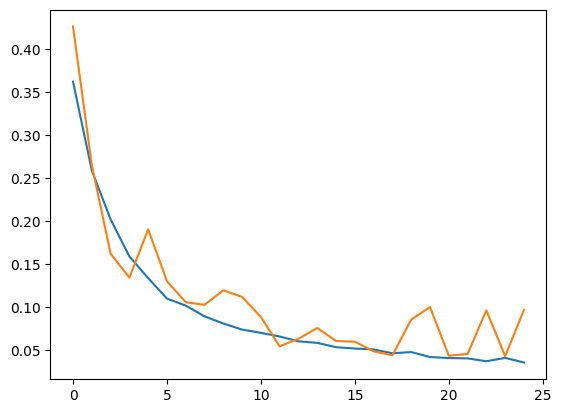

In [21]:
plt.plot(1 - np.array(acc))
plt.plot(1 - np.array(val_acc))

If the validation accuracy is much lower than the training accuracy: This is an indication of overfitting, which means that the model is performing well on the training data but not generalizing well to new, unseen data. You might want to try strategies like adding regularization (like dropout), reducing the model's complexity, or collecting more training data.

If the validation accuracy is similar or higher than the training accuracy: This suggests that your model is generalizing well. However, if the validation accuracy is consistently higher than the training accuracy, it could suggest that your validation set might not be representative of the overall data distribution, or it could be that your model is underfitting.

# Shallower and Deeper networks test

### deeper model

In [22]:
def make_deeper_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape)
        
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    previous_block_activation = x
    for size in [256, 512, 768, 824, 964]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        
        x = layers.add([x, residual])
        previous_block_activation = x
        
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [23]:
deeper_model = make_deeper_model(input_shape=image_size + (3,), num_classes=2)
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")
]

deeper_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

deeper_model_history = deeper_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds
)

Epoch 1/25


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:29 - loss: 0.7536 - accuracy: 0.5725

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:20 - loss: 0.7241 - accuracy: 0.5841

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 1:01 - loss: 0.7026 - accuracy: 0.5991

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 55s - loss: 0.6994 - accuracy: 0.6003

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 53s - loss: 0.6951 - accuracy: 0.6033

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 47s - loss: 0.6873 - accuracy: 0.6110

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 42s - loss: 0.6815 - accuracy: 0.6139

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 42s - loss: 0.6810 - accuracy: 0.6144

529/586 [==========================>...] - ETA: 10s - loss: 0.6518 - accuracy: 0.6411

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.6429 - accuracy: 0.6470

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 134s 195ms/step - loss: 0.6429 - accuracy: 0.6470 - val_loss: 0.6006 - val_accuracy: 0.6595
Epoch 2/25
  4/586 [..............................] - ETA: 2:11 - loss: 0.5054 - accuracy: 0.7656

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:34 - loss: 0.5632 - accuracy: 0.7092

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:23 - loss: 0.5554 - accuracy: 0.7192

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 1:02 - loss: 0.5426 - accuracy: 0.7290

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 56s - loss: 0.5418 - accuracy: 0.7289

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 54s - loss: 0.5394 - accuracy: 0.7303

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 48s - loss: 0.5390 - accuracy: 0.7313

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 43s - loss: 0.5383 - accuracy: 0.7317

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 43s - loss: 0.5376 - accuracy: 0.7320

529/586 [==========================>...] - ETA: 10s - loss: 0.5192 - accuracy: 0.7444

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.5134 - accuracy: 0.7484

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 113s 192ms/step - loss: 0.5134 - accuracy: 0.7484 - val_loss: 0.6506 - val_accuracy: 0.6493
Epoch 3/25
  4/586 [..............................] - ETA: 2:13 - loss: 0.4864 - accuracy: 0.7812

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:34 - loss: 0.4544 - accuracy: 0.7879

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:23 - loss: 0.4506 - accuracy: 0.7835

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 1:02 - loss: 0.4470 - accuracy: 0.7891

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 56s - loss: 0.4498 - accuracy: 0.7869

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 54s - loss: 0.4473 - accuracy: 0.7888

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 48s - loss: 0.4411 - accuracy: 0.7917

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 43s - loss: 0.4391 - accuracy: 0.7932

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 43s - loss: 0.4384 - accuracy: 0.7936

529/586 [==========================>...] - ETA: 10s - loss: 0.4133 - accuracy: 0.8091

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.4073 - accuracy: 0.8124

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 114s 192ms/step - loss: 0.4073 - accuracy: 0.8124 - val_loss: 0.5237 - val_accuracy: 0.7290
Epoch 4/25
  3/586 [..............................] - ETA: 1:53 - loss: 0.4158 - accuracy: 0.7604

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:34 - loss: 0.3229 - accuracy: 0.8542

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:23 - loss: 0.3337 - accuracy: 0.8500

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 1:02 - loss: 0.3322 - accuracy: 0.8507

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 56s - loss: 0.3317 - accuracy: 0.8510

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 54s - loss: 0.3294 - accuracy: 0.8529

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 48s - loss: 0.3259 - accuracy: 0.8547

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 43s - loss: 0.3259 - accuracy: 0.8554

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 43s - loss: 0.3258 - accuracy: 0.8556

529/586 [==========================>...] - ETA: 10s - loss: 0.3117 - accuracy: 0.8632

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.3115 - accuracy: 0.8628

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 114s 192ms/step - loss: 0.3115 - accuracy: 0.8628 - val_loss: 0.2749 - val_accuracy: 0.8832
Epoch 5/25
  2/586 [..............................] - ETA: 1:49 - loss: 0.2470 - accuracy: 0.8750 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:34 - loss: 0.2413 - accuracy: 0.8921

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:23 - loss: 0.2673 - accuracy: 0.8785

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 1:02 - loss: 0.2673 - accuracy: 0.8797

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 56s - loss: 0.2664 - accuracy: 0.8810

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 54s - loss: 0.2662 - accuracy: 0.8808

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 48s - loss: 0.2638 - accuracy: 0.8824

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 43s - loss: 0.2624 - accuracy: 0.8834

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 43s - loss: 0.2624 - accuracy: 0.8836

529/586 [==========================>...] - ETA: 10s - loss: 0.2588 - accuracy: 0.8863

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2593 - accuracy: 0.8865

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 114s 192ms/step - loss: 0.2593 - accuracy: 0.8865 - val_loss: 0.2792 - val_accuracy: 0.8793
Epoch 6/25
  3/586 [..............................] - ETA: 1:52 - loss: 0.2844 - accuracy: 0.8438

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:34 - loss: 0.2303 - accuracy: 0.9054

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:23 - loss: 0.2371 - accuracy: 0.9035

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 1:02 - loss: 0.2378 - accuracy: 0.9027

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 56s - loss: 0.2339 - accuracy: 0.9041

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 54s - loss: 0.2331 - accuracy: 0.9042

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 48s - loss: 0.2335 - accuracy: 0.9030

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 43s - loss: 0.2333 - accuracy: 0.9028

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 43s - loss: 0.2329 - accuracy: 0.9027

529/586 [==========================>...] - ETA: 10s - loss: 0.2280 - accuracy: 0.9051

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2289 - accuracy: 0.9044

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 114s 192ms/step - loss: 0.2289 - accuracy: 0.9044 - val_loss: 0.2381 - val_accuracy: 0.9018
Epoch 7/25
  2/586 [..............................] - ETA: 2:06 - loss: 0.2092 - accuracy: 0.8906 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:35 - loss: 0.1984 - accuracy: 0.9179

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:24 - loss: 0.2074 - accuracy: 0.9147

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 1:02 - loss: 0.2088 - accuracy: 0.9143

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 56s - loss: 0.2117 - accuracy: 0.9128

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 54s - loss: 0.2115 - accuracy: 0.9133

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 48s - loss: 0.2098 - accuracy: 0.9138

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 43s - loss: 0.2078 - accuracy: 0.9141

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 43s - loss: 0.2074 - accuracy: 0.9140

529/586 [==========================>...] - ETA: 10s - loss: 0.2058 - accuracy: 0.9143

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2068 - accuracy: 0.9133

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 114s 193ms/step - loss: 0.2068 - accuracy: 0.9133 - val_loss: 0.1810 - val_accuracy: 0.9299
Epoch 8/25
  3/586 [..............................] - ETA: 2:23 - loss: 0.1544 - accuracy: 0.9375

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:34 - loss: 0.1873 - accuracy: 0.9262

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:23 - loss: 0.1811 - accuracy: 0.9286

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 1:02 - loss: 0.1871 - accuracy: 0.9250

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 56s - loss: 0.1891 - accuracy: 0.9244

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 54s - loss: 0.1897 - accuracy: 0.9240

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 48s - loss: 0.1884 - accuracy: 0.9248

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 43s - loss: 0.1906 - accuracy: 0.9232

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 43s - loss: 0.1903 - accuracy: 0.9232

529/586 [==========================>...] - ETA: 10s - loss: 0.1832 - accuracy: 0.9257

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1841 - accuracy: 0.9251

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 114s 193ms/step - loss: 0.1841 - accuracy: 0.9251 - val_loss: 0.2265 - val_accuracy: 0.9000
Epoch 9/25
  4/586 [..............................] - ETA: 1:54 - loss: 0.2558 - accuracy: 0.8984

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:34 - loss: 0.1776 - accuracy: 0.9287

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:23 - loss: 0.1784 - accuracy: 0.9273

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 1:02 - loss: 0.1850 - accuracy: 0.9240

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 56s - loss: 0.1847 - accuracy: 0.9247

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 54s - loss: 0.1838 - accuracy: 0.9247

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 48s - loss: 0.1808 - accuracy: 0.9264

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 43s - loss: 0.1795 - accuracy: 0.9264

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 43s - loss: 0.1794 - accuracy: 0.9264

529/586 [==========================>...] - ETA: 10s - loss: 0.1752 - accuracy: 0.9287

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1750 - accuracy: 0.9287

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 114s 193ms/step - loss: 0.1750 - accuracy: 0.9287 - val_loss: 0.1643 - val_accuracy: 0.9338
Epoch 10/25
  3/586 [..............................] - ETA: 2:21 - loss: 0.1640 - accuracy: 0.9479

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:33 - loss: 0.1720 - accuracy: 0.9329

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:23 - loss: 0.1716 - accuracy: 0.9328

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 1:02 - loss: 0.1717 - accuracy: 0.9301

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 56s - loss: 0.1710 - accuracy: 0.9307

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 54s - loss: 0.1705 - accuracy: 0.9302

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 48s - loss: 0.1705 - accuracy: 0.9298

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 43s - loss: 0.1706 - accuracy: 0.9290

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 43s - loss: 0.1705 - accuracy: 0.9291

529/586 [==========================>...] - ETA: 10s - loss: 0.1660 - accuracy: 0.9322

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1642 - accuracy: 0.9321

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 114s 192ms/step - loss: 0.1642 - accuracy: 0.9321 - val_loss: 0.1680 - val_accuracy: 0.9267
Epoch 11/25
  2/586 [..............................] - ETA: 1:48 - loss: 0.1071 - accuracy: 0.9844 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:35 - loss: 0.1506 - accuracy: 0.9325

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:24 - loss: 0.1530 - accuracy: 0.9345

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 1:02 - loss: 0.1582 - accuracy: 0.9320

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 56s - loss: 0.1601 - accuracy: 0.9319

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 54s - loss: 0.1583 - accuracy: 0.9326

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 48s - loss: 0.1616 - accuracy: 0.9313

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 43s - loss: 0.1625 - accuracy: 0.9302

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 43s - loss: 0.1624 - accuracy: 0.9302

529/586 [==========================>...] - ETA: 10s - loss: 0.1552 - accuracy: 0.9332

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1549 - accuracy: 0.9338

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 114s 193ms/step - loss: 0.1549 - accuracy: 0.9338 - val_loss: 0.1570 - val_accuracy: 0.9331
Epoch 12/25
  3/586 [..............................] - ETA: 1:49 - loss: 0.1362 - accuracy: 0.9375

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:34 - loss: 0.1462 - accuracy: 0.9371

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:23 - loss: 0.1472 - accuracy: 0.9385

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 1:02 - loss: 0.1471 - accuracy: 0.9378

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 56s - loss: 0.1453 - accuracy: 0.9382

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 54s - loss: 0.1468 - accuracy: 0.9373

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 48s - loss: 0.1479 - accuracy: 0.9375

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 43s - loss: 0.1465 - accuracy: 0.9378

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 43s - loss: 0.1469 - accuracy: 0.9375

529/586 [==========================>...] - ETA: 10s - loss: 0.1444 - accuracy: 0.9397

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1435 - accuracy: 0.9407

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 113s 192ms/step - loss: 0.1435 - accuracy: 0.9407 - val_loss: 0.3812 - val_accuracy: 0.8563
Epoch 13/25
  3/586 [..............................] - ETA: 1:54 - loss: 0.2024 - accuracy: 0.9167

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:35 - loss: 0.1462 - accuracy: 0.9392

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:23 - loss: 0.1540 - accuracy: 0.9360

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 1:02 - loss: 0.1522 - accuracy: 0.9384

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 56s - loss: 0.1542 - accuracy: 0.9367

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 54s - loss: 0.1525 - accuracy: 0.9377

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 48s - loss: 0.1501 - accuracy: 0.9391

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 43s - loss: 0.1489 - accuracy: 0.9393

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 43s - loss: 0.1486 - accuracy: 0.9394

529/586 [==========================>...] - ETA: 10s - loss: 0.1394 - accuracy: 0.9431

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1400 - accuracy: 0.9427

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 114s 193ms/step - loss: 0.1400 - accuracy: 0.9427 - val_loss: 0.1697 - val_accuracy: 0.9276
Epoch 14/25
  4/586 [..............................] - ETA: 2:13 - loss: 0.1235 - accuracy: 0.9453

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:34 - loss: 0.1260 - accuracy: 0.9458

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:23 - loss: 0.1260 - accuracy: 0.9462

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 1:02 - loss: 0.1308 - accuracy: 0.9463

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 56s - loss: 0.1311 - accuracy: 0.9473

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 54s - loss: 0.1306 - accuracy: 0.9472

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 48s - loss: 0.1317 - accuracy: 0.9465

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 43s - loss: 0.1328 - accuracy: 0.9460

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 43s - loss: 0.1329 - accuracy: 0.9458

529/586 [==========================>...] - ETA: 10s - loss: 0.1320 - accuracy: 0.9466

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1314 - accuracy: 0.9460

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 114s 193ms/step - loss: 0.1314 - accuracy: 0.9460 - val_loss: 0.3135 - val_accuracy: 0.8599
Epoch 15/25
  3/586 [..............................] - ETA: 1:52 - loss: 0.0849 - accuracy: 0.9479

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:34 - loss: 0.1232 - accuracy: 0.9483

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:23 - loss: 0.1227 - accuracy: 0.9459

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 1:02 - loss: 0.1287 - accuracy: 0.9464

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 56s - loss: 0.1261 - accuracy: 0.9476

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 54s - loss: 0.1265 - accuracy: 0.9474

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 48s - loss: 0.1246 - accuracy: 0.9483

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 43s - loss: 0.1261 - accuracy: 0.9469

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 43s - loss: 0.1259 - accuracy: 0.9470

529/586 [==========================>...] - ETA: 10s - loss: 0.1259 - accuracy: 0.9479

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1270 - accuracy: 0.9472

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 114s 193ms/step - loss: 0.1270 - accuracy: 0.9472 - val_loss: 0.5601 - val_accuracy: 0.7698
Epoch 16/25
  3/586 [..............................] - ETA: 2:27 - loss: 0.0915 - accuracy: 0.9688

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:34 - loss: 0.1190 - accuracy: 0.9533

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:23 - loss: 0.1305 - accuracy: 0.9479

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 1:02 - loss: 0.1313 - accuracy: 0.9460

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 56s - loss: 0.1288 - accuracy: 0.9469

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 54s - loss: 0.1274 - accuracy: 0.9472

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 48s - loss: 0.1277 - accuracy: 0.9473

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 43s - loss: 0.1283 - accuracy: 0.9462

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 43s - loss: 0.1283 - accuracy: 0.9460

529/586 [==========================>...] - ETA: 10s - loss: 0.1234 - accuracy: 0.9481

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1224 - accuracy: 0.9487

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 114s 193ms/step - loss: 0.1224 - accuracy: 0.9487 - val_loss: 0.1894 - val_accuracy: 0.9238
Epoch 17/25
  3/586 [..............................] - ETA: 1:53 - loss: 0.1181 - accuracy: 0.9271

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:34 - loss: 0.1142 - accuracy: 0.9521

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:23 - loss: 0.1163 - accuracy: 0.9514

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 1:02 - loss: 0.1224 - accuracy: 0.9512

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 56s - loss: 0.1200 - accuracy: 0.9519

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 54s - loss: 0.1194 - accuracy: 0.9517

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 48s - loss: 0.1200 - accuracy: 0.9509

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 43s - loss: 0.1176 - accuracy: 0.9527

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 43s - loss: 0.1173 - accuracy: 0.9527

529/586 [==========================>...] - ETA: 10s - loss: 0.1146 - accuracy: 0.9537

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1149 - accuracy: 0.9534

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 114s 193ms/step - loss: 0.1149 - accuracy: 0.9534 - val_loss: 0.1106 - val_accuracy: 0.9575
Epoch 18/25
  3/586 [..............................] - ETA: 2:51 - loss: 0.1005 - accuracy: 0.9688

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:35 - loss: 0.1089 - accuracy: 0.9579

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:24 - loss: 0.1122 - accuracy: 0.9566

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 1:02 - loss: 0.1209 - accuracy: 0.9521

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 56s - loss: 0.1203 - accuracy: 0.9519

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 54s - loss: 0.1187 - accuracy: 0.9524

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 48s - loss: 0.1170 - accuracy: 0.9533

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 43s - loss: 0.1147 - accuracy: 0.9544

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 43s - loss: 0.1142 - accuracy: 0.9546

529/586 [==========================>...] - ETA: 10s - loss: 0.1126 - accuracy: 0.9559

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1128 - accuracy: 0.9559

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 114s 193ms/step - loss: 0.1128 - accuracy: 0.9559 - val_loss: 0.1269 - val_accuracy: 0.9462
Epoch 19/25
  3/586 [..............................] - ETA: 2:37 - loss: 0.0515 - accuracy: 0.9792

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:34 - loss: 0.1296 - accuracy: 0.9471

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:23 - loss: 0.1244 - accuracy: 0.9482

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 1:02 - loss: 0.1216 - accuracy: 0.9506

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 56s - loss: 0.1177 - accuracy: 0.9525

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 54s - loss: 0.1165 - accuracy: 0.9524

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 48s - loss: 0.1165 - accuracy: 0.9519

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 43s - loss: 0.1152 - accuracy: 0.9525

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 43s - loss: 0.1152 - accuracy: 0.9525

529/586 [==========================>...] - ETA: 10s - loss: 0.1143 - accuracy: 0.9539

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1125 - accuracy: 0.9545

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 114s 193ms/step - loss: 0.1125 - accuracy: 0.9545 - val_loss: 0.1194 - val_accuracy: 0.9556
Epoch 20/25
  3/586 [..............................] - ETA: 1:42 - loss: 0.0617 - accuracy: 0.9688

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:34 - loss: 0.1003 - accuracy: 0.9617

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:23 - loss: 0.1083 - accuracy: 0.9546

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 1:02 - loss: 0.1163 - accuracy: 0.9518

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 56s - loss: 0.1176 - accuracy: 0.9513

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 54s - loss: 0.1170 - accuracy: 0.9517

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 48s - loss: 0.1140 - accuracy: 0.9525

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 43s - loss: 0.1127 - accuracy: 0.9529

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 43s - loss: 0.1125 - accuracy: 0.9529

529/586 [==========================>...] - ETA: 10s - loss: 0.1087 - accuracy: 0.9553

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1075 - accuracy: 0.9553

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 114s 192ms/step - loss: 0.1075 - accuracy: 0.9553 - val_loss: 0.2607 - val_accuracy: 0.9088
Epoch 21/25
  3/586 [..............................] - ETA: 1:52 - loss: 0.1537 - accuracy: 0.9271

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:34 - loss: 0.1036 - accuracy: 0.9554

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:23 - loss: 0.1021 - accuracy: 0.9559

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 1:02 - loss: 0.1041 - accuracy: 0.9568

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 56s - loss: 0.1014 - accuracy: 0.9588

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 54s - loss: 0.1013 - accuracy: 0.9585

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 48s - loss: 0.0997 - accuracy: 0.9586

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 43s - loss: 0.1000 - accuracy: 0.9587

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 43s - loss: 0.1000 - accuracy: 0.9586

529/586 [==========================>...] - ETA: 10s - loss: 0.0976 - accuracy: 0.9602

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.0984 - accuracy: 0.9602

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 114s 193ms/step - loss: 0.0984 - accuracy: 0.9602 - val_loss: 0.1116 - val_accuracy: 0.9543
Epoch 22/25
  3/586 [..............................] - ETA: 1:52 - loss: 0.1420 - accuracy: 0.9479

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 77/586 [==>...........................] - ETA: 1:33 - loss: 0.0960 - accuracy: 0.9647

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


128/586 [=====>........................] - ETA: 1:22 - loss: 0.0950 - accuracy: 0.9636

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


240/586 [===========>..................] - ETA: 1:01 - loss: 0.1027 - accuracy: 0.9607

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


272/586 [============>.................] - ETA: 56s - loss: 0.1007 - accuracy: 0.9611

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


283/586 [=============>................] - ETA: 54s - loss: 0.1005 - accuracy: 0.9610

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


317/586 [===============>..............] - ETA: 48s - loss: 0.1010 - accuracy: 0.9602

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 43s - loss: 0.0996 - accuracy: 0.9608

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


346/586 [================>.............] - ETA: 42s - loss: 0.0993 - accuracy: 0.9609

531/586 [==========================>...] - ETA: 9s - loss: 0.0971 - accuracy: 0.9611

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.0978 - accuracy: 0.9610

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 114s 192ms/step - loss: 0.0978 - accuracy: 0.9610 - val_loss: 0.1101 - val_accuracy: 0.9562
Epoch 23/25
  3/586 [..............................] - ETA: 1:52 - loss: 0.0668 - accuracy: 0.9896

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 71/586 [==>...........................] - ETA: 1:35 - loss: 0.0953 - accuracy: 0.9595

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


122/586 [=====>........................] - ETA: 1:24 - loss: 0.0972 - accuracy: 0.9603

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


234/586 [==========>...................] - ETA: 1:03 - loss: 0.1044 - accuracy: 0.9590

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


266/586 [============>.................] - ETA: 57s - loss: 0.1014 - accuracy: 0.9596

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


277/586 [=============>................] - ETA: 55s - loss: 0.1013 - accuracy: 0.9598

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


311/586 [==============>...............] - ETA: 49s - loss: 0.1001 - accuracy: 0.9598

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


338/586 [================>.............] - ETA: 44s - loss: 0.0993 - accuracy: 0.9602

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


340/586 [================>.............] - ETA: 43s - loss: 0.0993 - accuracy: 0.9601

525/586 [=========================>....] - ETA: 10s - loss: 0.0955 - accuracy: 0.9618

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.0959 - accuracy: 0.9619

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 114s 192ms/step - loss: 0.0959 - accuracy: 0.9619 - val_loss: 0.1455 - val_accuracy: 0.9404
Epoch 24/25
  2/586 [..............................] - ETA: 1:42 - loss: 0.1253 - accuracy: 0.9531 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:33 - loss: 0.0963 - accuracy: 0.9608

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:23 - loss: 0.0991 - accuracy: 0.9616

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 1:02 - loss: 0.0991 - accuracy: 0.9617

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 56s - loss: 0.0967 - accuracy: 0.9620

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 54s - loss: 0.0954 - accuracy: 0.9624

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 48s - loss: 0.0951 - accuracy: 0.9618

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 43s - loss: 0.0946 - accuracy: 0.9616

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 43s - loss: 0.0946 - accuracy: 0.9618

529/586 [==========================>...] - ETA: 10s - loss: 0.0932 - accuracy: 0.9617

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.0932 - accuracy: 0.9614

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 114s 193ms/step - loss: 0.0932 - accuracy: 0.9614 - val_loss: 0.1014 - val_accuracy: 0.9613
Epoch 25/25
  3/586 [..............................] - ETA: 1:52 - loss: 0.0893 - accuracy: 0.9792

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/586 [==>...........................] - ETA: 1:34 - loss: 0.1082 - accuracy: 0.9554

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


126/586 [=====>........................] - ETA: 1:23 - loss: 0.0991 - accuracy: 0.9586

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/586 [===========>..................] - ETA: 1:02 - loss: 0.1014 - accuracy: 0.9589

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


270/586 [============>.................] - ETA: 56s - loss: 0.1022 - accuracy: 0.9583

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/586 [=============>................] - ETA: 54s - loss: 0.1021 - accuracy: 0.9583

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


315/586 [===============>..............] - ETA: 48s - loss: 0.0998 - accuracy: 0.9596

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


342/586 [================>.............] - ETA: 43s - loss: 0.0972 - accuracy: 0.9603

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


344/586 [================>.............] - ETA: 43s - loss: 0.0969 - accuracy: 0.9605

529/586 [==========================>...] - ETA: 10s - loss: 0.0946 - accuracy: 0.9622

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.0945 - accuracy: 0.9621

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 114s 193ms/step - loss: 0.0945 - accuracy: 0.9621 - val_loss: 0.1080 - val_accuracy: 0.9577


In [24]:

acc = deeper_model_history.history['accuracy']
val_acc = deeper_model_history.history['val_accuracy']
loss = deeper_model_history.history['loss']
val_loss = deeper_model_history.history['val_loss']

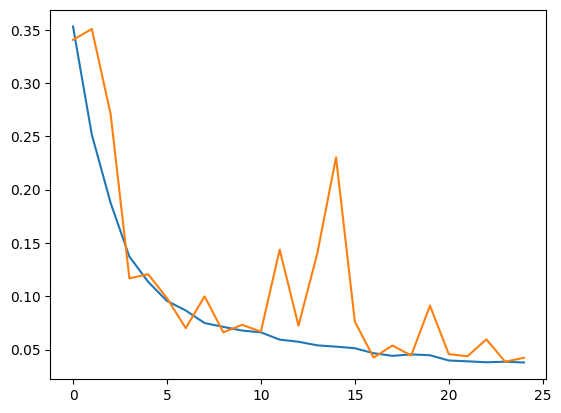

In [25]:
plt.plot(1 - np.array(acc))
plt.plot(1 - np.array(val_acc))

### Shallower model

In [26]:
def make_shallower_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape)
        
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    previous_block_activation = x
    for size in [512, 1024, 2048]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        
        x = layers.add([x, residual])
        previous_block_activation = x
        
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [27]:
shallower_model = make_shallower_model(input_shape=image_size + (3,), num_classes=2)
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")
]

shallower_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

shallower_model_history = shallower_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds
)

Epoch 1/25


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:21 - loss: 0.7376 - accuracy: 0.5693

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:01 - loss: 0.7176 - accuracy: 0.5738

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:17 - loss: 0.7026 - accuracy: 0.5839

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:05 - loss: 0.7015 - accuracy: 0.5828

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:00 - loss: 0.6998 - accuracy: 0.5843

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:47 - loss: 0.6982 - accuracy: 0.5860

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:36 - loss: 0.6965 - accuracy: 0.5849

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:35 - loss: 0.6961 - accuracy: 0.5855

528/586 [==========================>...] - ETA: 22s - loss: 0.6752 - accuracy: 0.6043

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.6713 - accuracy: 0.6075

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 278s 435ms/step - loss: 0.6713 - accuracy: 0.6075 - val_loss: 0.6969 - val_accuracy: 0.5961
Epoch 2/25
  1/586 [..............................] - ETA: 12:32 - loss: 0.5400 - accuracy: 0.7188

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:25 - loss: 0.6056 - accuracy: 0.6786

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.5948 - accuracy: 0.6812

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.5911 - accuracy: 0.6878

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:06 - loss: 0.5909 - accuracy: 0.6888

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.5901 - accuracy: 0.6878

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:48 - loss: 0.5891 - accuracy: 0.6895

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.5869 - accuracy: 0.6904

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.5864 - accuracy: 0.6908

528/586 [==========================>...] - ETA: 23s - loss: 0.5763 - accuracy: 0.7015

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.5742 - accuracy: 0.7030

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 252s 429ms/step - loss: 0.5742 - accuracy: 0.7030 - val_loss: 0.5233 - val_accuracy: 0.7482
Epoch 3/25
  1/586 [..............................] - ETA: 13:47 - loss: 0.3676 - accuracy: 0.7812

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:25 - loss: 0.5345 - accuracy: 0.7373

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:04 - loss: 0.5264 - accuracy: 0.7433

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.5227 - accuracy: 0.7459

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:06 - loss: 0.5249 - accuracy: 0.7464

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.5213 - accuracy: 0.7489

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:48 - loss: 0.5166 - accuracy: 0.7520

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.5112 - accuracy: 0.7544

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.5113 - accuracy: 0.7546

528/586 [==========================>...] - ETA: 23s - loss: 0.4928 - accuracy: 0.7675

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.4883 - accuracy: 0.7716

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 252s 429ms/step - loss: 0.4883 - accuracy: 0.7716 - val_loss: 0.4582 - val_accuracy: 0.7879
Epoch 4/25
  1/586 [..............................] - ETA: 12:24 - loss: 0.4754 - accuracy: 0.8125

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:24 - loss: 0.4254 - accuracy: 0.8083

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.4309 - accuracy: 0.8005

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.4400 - accuracy: 0.7971

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:06 - loss: 0.4410 - accuracy: 0.7964

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.4414 - accuracy: 0.7956

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:48 - loss: 0.4351 - accuracy: 0.8002

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.4301 - accuracy: 0.8036

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.4301 - accuracy: 0.8038

528/586 [==========================>...] - ETA: 23s - loss: 0.4171 - accuracy: 0.8123

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.4135 - accuracy: 0.8146

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 252s 428ms/step - loss: 0.4135 - accuracy: 0.8146 - val_loss: 0.4951 - val_accuracy: 0.7582
Epoch 5/25
  1/586 [..............................] - ETA: 12:11 - loss: 0.3871 - accuracy: 0.7812

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:25 - loss: 0.3849 - accuracy: 0.8323

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.3829 - accuracy: 0.8315

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.3807 - accuracy: 0.8343

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:06 - loss: 0.3780 - accuracy: 0.8347

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.3755 - accuracy: 0.8356

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:48 - loss: 0.3726 - accuracy: 0.8372

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.3740 - accuracy: 0.8361

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.3734 - accuracy: 0.8361

528/586 [==========================>...] - ETA: 23s - loss: 0.3565 - accuracy: 0.8453

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.3528 - accuracy: 0.8466

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 252s 428ms/step - loss: 0.3528 - accuracy: 0.8466 - val_loss: 0.3106 - val_accuracy: 0.8731
Epoch 6/25
  1/586 [..............................] - ETA: 12:27 - loss: 0.4129 - accuracy: 0.8438

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 76/586 [==>...........................] - ETA: 3:23 - loss: 0.3283 - accuracy: 0.8557

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


127/586 [=====>........................] - ETA: 3:02 - loss: 0.3219 - accuracy: 0.8595

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


239/586 [===========>..................] - ETA: 2:17 - loss: 0.3190 - accuracy: 0.8617

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


271/586 [============>.................] - ETA: 2:04 - loss: 0.3162 - accuracy: 0.8636

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


282/586 [=============>................] - ETA: 2:00 - loss: 0.3141 - accuracy: 0.8649

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


316/586 [===============>..............] - ETA: 1:47 - loss: 0.3101 - accuracy: 0.8656

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.3089 - accuracy: 0.8671

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


345/586 [================>.............] - ETA: 1:35 - loss: 0.3086 - accuracy: 0.8671

530/586 [==========================>...] - ETA: 22s - loss: 0.2980 - accuracy: 0.8715

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2967 - accuracy: 0.8718

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 251s 428ms/step - loss: 0.2967 - accuracy: 0.8718 - val_loss: 0.3726 - val_accuracy: 0.8381
Epoch 7/25
  1/586 [..............................] - ETA: 12:38 - loss: 0.2441 - accuracy: 0.8750

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:25 - loss: 0.2682 - accuracy: 0.8915

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.2703 - accuracy: 0.8890

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.2762 - accuracy: 0.8846

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:06 - loss: 0.2835 - accuracy: 0.8806

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.2830 - accuracy: 0.8805

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:48 - loss: 0.2781 - accuracy: 0.8831

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.2783 - accuracy: 0.8822

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.2783 - accuracy: 0.8821

528/586 [==========================>...] - ETA: 23s - loss: 0.2702 - accuracy: 0.8862

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2694 - accuracy: 0.8868

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 252s 428ms/step - loss: 0.2694 - accuracy: 0.8868 - val_loss: 0.2164 - val_accuracy: 0.9180
Epoch 8/25
  2/586 [..............................] - ETA: 4:18 - loss: 0.4214 - accuracy: 0.8125 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:24 - loss: 0.2505 - accuracy: 0.8919

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.2429 - accuracy: 0.8960

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.2435 - accuracy: 0.8969

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:05 - loss: 0.2452 - accuracy: 0.8961

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.2431 - accuracy: 0.8967

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:48 - loss: 0.2432 - accuracy: 0.8964

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.2467 - accuracy: 0.8962

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.2469 - accuracy: 0.8960

528/586 [==========================>...] - ETA: 23s - loss: 0.2399 - accuracy: 0.8996

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2387 - accuracy: 0.8995

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 252s 428ms/step - loss: 0.2387 - accuracy: 0.8995 - val_loss: 0.3208 - val_accuracy: 0.8518
Epoch 9/25
  1/586 [..............................] - ETA: 12:31 - loss: 0.2949 - accuracy: 0.8438

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:25 - loss: 0.2072 - accuracy: 0.9155

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.2194 - accuracy: 0.9080

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.2190 - accuracy: 0.9081

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:06 - loss: 0.2212 - accuracy: 0.9072

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.2217 - accuracy: 0.9069

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:48 - loss: 0.2191 - accuracy: 0.9074

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.2199 - accuracy: 0.9080

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.2195 - accuracy: 0.9083

528/586 [==========================>...] - ETA: 23s - loss: 0.2102 - accuracy: 0.9128

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2090 - accuracy: 0.9129

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 252s 428ms/step - loss: 0.2090 - accuracy: 0.9129 - val_loss: 0.1879 - val_accuracy: 0.9321
Epoch 10/25
  1/586 [..............................] - ETA: 12:56 - loss: 0.2654 - accuracy: 0.8438

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:24 - loss: 0.1931 - accuracy: 0.9198

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.1902 - accuracy: 0.9195

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.2022 - accuracy: 0.9159

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:05 - loss: 0.2002 - accuracy: 0.9171

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.1990 - accuracy: 0.9176

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:47 - loss: 0.1984 - accuracy: 0.9180

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.1987 - accuracy: 0.9179

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.1988 - accuracy: 0.9177

528/586 [==========================>...] - ETA: 23s - loss: 0.1948 - accuracy: 0.9193

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1934 - accuracy: 0.9203

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 252s 428ms/step - loss: 0.1934 - accuracy: 0.9203 - val_loss: 0.3081 - val_accuracy: 0.8821
Epoch 11/25
  1/586 [..............................] - ETA: 13:42 - loss: 0.2084 - accuracy: 0.9375

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:24 - loss: 0.1856 - accuracy: 0.9231

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.1874 - accuracy: 0.9212

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.1903 - accuracy: 0.9226

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:06 - loss: 0.1864 - accuracy: 0.9243

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.1849 - accuracy: 0.9249

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:48 - loss: 0.1818 - accuracy: 0.9263

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.1845 - accuracy: 0.9249

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.1846 - accuracy: 0.9249

528/586 [==========================>...] - ETA: 23s - loss: 0.1785 - accuracy: 0.9288

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1774 - accuracy: 0.9289

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 252s 429ms/step - loss: 0.1774 - accuracy: 0.9289 - val_loss: 0.1760 - val_accuracy: 0.9259
Epoch 12/25
  1/586 [..............................] - ETA: 13:09 - loss: 0.1385 - accuracy: 0.9375

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:25 - loss: 0.1825 - accuracy: 0.9265

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:04 - loss: 0.1762 - accuracy: 0.9315

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.1856 - accuracy: 0.9271

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:06 - loss: 0.1806 - accuracy: 0.9287

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.1784 - accuracy: 0.9302

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:48 - loss: 0.1781 - accuracy: 0.9297

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.1777 - accuracy: 0.9300

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.1779 - accuracy: 0.9298

528/586 [==========================>...] - ETA: 23s - loss: 0.1693 - accuracy: 0.9327

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1688 - accuracy: 0.9326

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 252s 428ms/step - loss: 0.1688 - accuracy: 0.9326 - val_loss: 0.2461 - val_accuracy: 0.8924
Epoch 13/25
  1/586 [..............................] - ETA: 12:38 - loss: 0.5340 - accuracy: 0.8125

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:24 - loss: 0.1640 - accuracy: 0.9341

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.1656 - accuracy: 0.9323

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.1637 - accuracy: 0.9362

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:06 - loss: 0.1612 - accuracy: 0.9356

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.1603 - accuracy: 0.9360

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:48 - loss: 0.1577 - accuracy: 0.9375

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.1607 - accuracy: 0.9363

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.1603 - accuracy: 0.9366

528/586 [==========================>...] - ETA: 23s - loss: 0.1577 - accuracy: 0.9373

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1564 - accuracy: 0.9376

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 252s 428ms/step - loss: 0.1564 - accuracy: 0.9376 - val_loss: 0.3194 - val_accuracy: 0.8366
Epoch 14/25
  1/586 [..............................] - ETA: 13:31 - loss: 0.2380 - accuracy: 0.9062

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:25 - loss: 0.1651 - accuracy: 0.9312

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:04 - loss: 0.1597 - accuracy: 0.9348

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.1613 - accuracy: 0.9358

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:05 - loss: 0.1573 - accuracy: 0.9370

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.1576 - accuracy: 0.9367

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:48 - loss: 0.1527 - accuracy: 0.9390

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.1516 - accuracy: 0.9393

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.1515 - accuracy: 0.9393

525/586 [=========================>....] - ETA: 24s - loss: 0.1478 - accuracy: 0.9402

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



528/586 [==========================>...] - ETA: 23s - loss: 0.1211 - accuracy: 0.9523

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1205 - accuracy: 0.9525

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 252s 428ms/step - loss: 0.1205 - accuracy: 0.9525 - val_loss: 0.1566 - val_accuracy: 0.9408
Epoch 21/25
  2/586 [..............................] - ETA: 4:20 - loss: 0.1168 - accuracy: 0.9531 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:25 - loss: 0.1002 - accuracy: 0.9573

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.1003 - accuracy: 0.9595

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.1078 - accuracy: 0.9564

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:05 - loss: 0.1104 - accuracy: 0.9550

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.1088 - accuracy: 0.9559

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:47 - loss: 0.1070 - accuracy: 0.9562

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.1078 - accuracy: 0.9562

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.1077 - accuracy: 0.9563

528/586 [==========================>...] - ETA: 23s - loss: 0.1069 - accuracy: 0.9563

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1069 - accuracy: 0.9566

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 252s 428ms/step - loss: 0.1069 - accuracy: 0.9566 - val_loss: 0.1298 - val_accuracy: 0.9479
Epoch 22/25
  1/586 [..............................] - ETA: 12:46 - loss: 0.0497 - accuracy: 0.9688

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:24 - loss: 0.1495 - accuracy: 0.9388

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.1354 - accuracy: 0.9450

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.1281 - accuracy: 0.9482

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:05 - loss: 0.1261 - accuracy: 0.9490

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.1259 - accuracy: 0.9493

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:47 - loss: 0.1232 - accuracy: 0.9503

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.1228 - accuracy: 0.9505

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.1224 - accuracy: 0.9507

528/586 [==========================>...] - ETA: 22s - loss: 0.1122 - accuracy: 0.9553

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1113 - accuracy: 0.9556

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 251s 427ms/step - loss: 0.1113 - accuracy: 0.9556 - val_loss: 0.1202 - val_accuracy: 0.9534
Epoch 23/25
  1/586 [..............................] - ETA: 13:03 - loss: 0.0447 - accuracy: 1.0000

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:24 - loss: 0.1152 - accuracy: 0.9595

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.1044 - accuracy: 0.9613

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.1117 - accuracy: 0.9590

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:05 - loss: 0.1094 - accuracy: 0.9605

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.1075 - accuracy: 0.9609

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:47 - loss: 0.1067 - accuracy: 0.9609

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.1059 - accuracy: 0.9609

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.1055 - accuracy: 0.9611

528/586 [==========================>...] - ETA: 22s - loss: 0.1020 - accuracy: 0.9620

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1009 - accuracy: 0.9624

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 252s 428ms/step - loss: 0.1009 - accuracy: 0.9624 - val_loss: 0.1218 - val_accuracy: 0.9537
Epoch 24/25
  1/586 [..............................] - ETA: 13:52 - loss: 0.0806 - accuracy: 0.9688

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:25 - loss: 0.0805 - accuracy: 0.9654

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.0922 - accuracy: 0.9628

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.1002 - accuracy: 0.9595

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:06 - loss: 0.0999 - accuracy: 0.9593

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.1001 - accuracy: 0.9586

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:48 - loss: 0.0992 - accuracy: 0.9590

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.0976 - accuracy: 0.9598

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.0974 - accuracy: 0.9598

528/586 [==========================>...] - ETA: 23s - loss: 0.0974 - accuracy: 0.9600

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.0972 - accuracy: 0.9602

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 252s 429ms/step - loss: 0.0972 - accuracy: 0.9602 - val_loss: 0.1166 - val_accuracy: 0.9556
Epoch 25/25
  1/586 [..............................] - ETA: 12:19 - loss: 0.0301 - accuracy: 1.0000

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:25 - loss: 0.0966 - accuracy: 0.9616

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.0991 - accuracy: 0.9582

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.1031 - accuracy: 0.9574

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:05 - loss: 0.1027 - accuracy: 0.9582

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.1020 - accuracy: 0.9581

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:48 - loss: 0.1017 - accuracy: 0.9582

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.1011 - accuracy: 0.9586

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.1012 - accuracy: 0.9585

407/586 [===================>..........] - ETA: 1:11 - loss: 0.0979 - accuracy: 0.9599

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



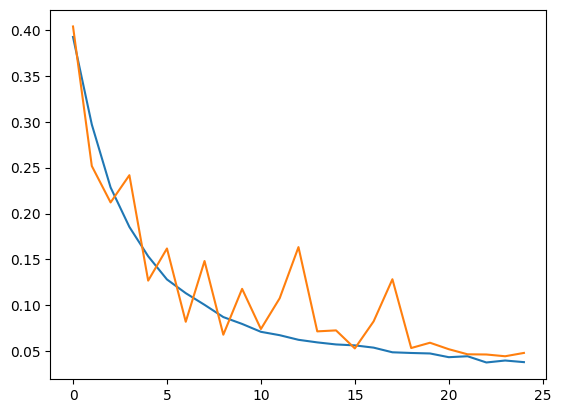

In [33]:
acc = shallower_model_history.history['accuracy']
val_acc = shallower_model_history.history['val_accuracy']
loss = shallower_model_history.history['loss']
val_loss = shallower_model_history.history['val_loss']

plt.plot(1 - np.array(acc))
plt.plot(1 - np.array(val_acc))

# Try different activation functions

### try sigmoid and tanh - expecting bad results because of vanishing gradients

#### sigmoid

In [28]:
def make_model_with_sigmoid_activation_f(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape)
        
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("sigmoid")(x)
    
    previous_block_activation = x
    for size in [512, 1024, 2048]:
        x = layers.Activation("sigmoid")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("sigmoid")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        
        x = layers.add([x, residual])
        previous_block_activation = x
        
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("sigmoid")(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [29]:
model_with_sigmoid_activation_f = make_model_with_sigmoid_activation_f(input_shape=image_size + (3,), num_classes=2)
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")
]

model_with_sigmoid_activation_f.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_with_sigmoid_activation_f_history = model_with_sigmoid_activation_f.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds
)

Epoch 1/25


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:21 - loss: 0.7553 - accuracy: 0.5258

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:01 - loss: 0.7267 - accuracy: 0.5543

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:17 - loss: 0.7087 - accuracy: 0.5750

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:05 - loss: 0.7070 - accuracy: 0.5775

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.7063 - accuracy: 0.5773

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:47 - loss: 0.7049 - accuracy: 0.5793

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:36 - loss: 0.7024 - accuracy: 0.5802

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.7026 - accuracy: 0.5800

528/586 [==========================>...] - ETA: 22s - loss: 0.6858 - accuracy: 0.5989

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.6825 - accuracy: 0.6028

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 262s 430ms/step - loss: 0.6825 - accuracy: 0.6028 - val_loss: 1.4151 - val_accuracy: 0.5058
Epoch 2/25
  2/586 [..............................] - ETA: 4:18 - loss: 0.6121 - accuracy: 0.6250 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:24 - loss: 0.6368 - accuracy: 0.6364

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.6420 - accuracy: 0.6357

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.6436 - accuracy: 0.6373

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:06 - loss: 0.6449 - accuracy: 0.6366

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.6447 - accuracy: 0.6368

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:48 - loss: 0.6421 - accuracy: 0.6376

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.6418 - accuracy: 0.6388

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.6416 - accuracy: 0.6388

528/586 [==========================>...] - ETA: 23s - loss: 0.6345 - accuracy: 0.6483

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.6330 - accuracy: 0.6501

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 253s 430ms/step - loss: 0.6330 - accuracy: 0.6501 - val_loss: 0.6113 - val_accuracy: 0.6927
Epoch 3/25
  1/586 [..............................] - ETA: 13:34 - loss: 0.5784 - accuracy: 0.7500

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:25 - loss: 0.5976 - accuracy: 0.6917

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.6021 - accuracy: 0.6888

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.6056 - accuracy: 0.6787

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:05 - loss: 0.6114 - accuracy: 0.6707

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.6123 - accuracy: 0.6692

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:47 - loss: 0.6089 - accuracy: 0.6719

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.6090 - accuracy: 0.6716

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.6087 - accuracy: 0.6717

528/586 [==========================>...] - ETA: 22s - loss: 0.5977 - accuracy: 0.6815

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.5954 - accuracy: 0.6845

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 252s 429ms/step - loss: 0.5954 - accuracy: 0.6845 - val_loss: 1.9720 - val_accuracy: 0.4951
Epoch 4/25
  2/586 [..............................] - ETA: 3:58 - loss: 0.5410 - accuracy: 0.7188 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:24 - loss: 0.5708 - accuracy: 0.7141

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.5617 - accuracy: 0.7232

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.5591 - accuracy: 0.7213

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:05 - loss: 0.5574 - accuracy: 0.7225

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.5585 - accuracy: 0.7213

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:47 - loss: 0.5557 - accuracy: 0.7229

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.5556 - accuracy: 0.7229

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.5552 - accuracy: 0.7234

528/586 [==========================>...] - ETA: 22s - loss: 0.5416 - accuracy: 0.7329

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.5390 - accuracy: 0.7352

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 253s 430ms/step - loss: 0.5390 - accuracy: 0.7352 - val_loss: 0.5968 - val_accuracy: 0.6664
Epoch 5/25
  1/586 [..............................] - ETA: 13:17 - loss: 0.5126 - accuracy: 0.6875

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:25 - loss: 0.5009 - accuracy: 0.7542

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.4983 - accuracy: 0.7592

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.5048 - accuracy: 0.7555

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:05 - loss: 0.5061 - accuracy: 0.7559

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.5048 - accuracy: 0.7569

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:47 - loss: 0.5024 - accuracy: 0.7579

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.5001 - accuracy: 0.7604

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.5006 - accuracy: 0.7601

528/586 [==========================>...] - ETA: 22s - loss: 0.4966 - accuracy: 0.7638

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.4965 - accuracy: 0.7636

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



528/586 [==========================>...] - ETA: 23s - loss: 0.3627 - accuracy: 0.8419

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.3611 - accuracy: 0.8433

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 253s 430ms/step - loss: 0.3611 - accuracy: 0.8433 - val_loss: 0.3544 - val_accuracy: 0.8464
Epoch 12/25
  1/586 [..............................] - ETA: 13:23 - loss: 0.3868 - accuracy: 0.7500

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:24 - loss: 0.3402 - accuracy: 0.8497

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:02 - loss: 0.3439 - accuracy: 0.8480

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.3427 - accuracy: 0.8505

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:05 - loss: 0.3464 - accuracy: 0.8487

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.3459 - accuracy: 0.8493

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:47 - loss: 0.3447 - accuracy: 0.8505

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:36 - loss: 0.3425 - accuracy: 0.8517

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.3419 - accuracy: 0.8519

528/586 [==========================>...] - ETA: 22s - loss: 0.3409 - accuracy: 0.8522

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.3408 - accuracy: 0.8522

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 252s 429ms/step - loss: 0.3408 - accuracy: 0.8522 - val_loss: 0.8548 - val_accuracy: 0.6657
Epoch 13/25
  1/586 [..............................] - ETA: 12:59 - loss: 0.4904 - accuracy: 0.7812

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:25 - loss: 0.3304 - accuracy: 0.8552

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.3358 - accuracy: 0.8547

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.3394 - accuracy: 0.8535

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:05 - loss: 0.3412 - accuracy: 0.8535

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.3395 - accuracy: 0.8536

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:48 - loss: 0.3376 - accuracy: 0.8539

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.3377 - accuracy: 0.8537

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.3372 - accuracy: 0.8540

528/586 [==========================>...] - ETA: 23s - loss: 0.3267 - accuracy: 0.8594

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.3276 - accuracy: 0.8589

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 253s 430ms/step - loss: 0.3276 - accuracy: 0.8589 - val_loss: 3.4480 - val_accuracy: 0.5051
Epoch 14/25
  1/586 [..............................] - ETA: 12:58 - loss: 0.3795 - accuracy: 0.8438

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:25 - loss: 0.2956 - accuracy: 0.8708

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:04 - loss: 0.2999 - accuracy: 0.8683

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.3136 - accuracy: 0.8647

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:06 - loss: 0.3165 - accuracy: 0.8638

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.3157 - accuracy: 0.8645

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:48 - loss: 0.3116 - accuracy: 0.8664

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.3095 - accuracy: 0.8664

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.3090 - accuracy: 0.8666

528/586 [==========================>...] - ETA: 23s - loss: 0.3068 - accuracy: 0.8702

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.3082 - accuracy: 0.8693

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 253s 430ms/step - loss: 0.3082 - accuracy: 0.8693 - val_loss: 2.7320 - val_accuracy: 0.5083
Epoch 15/25
  1/586 [..............................] - ETA: 12:22 - loss: 0.6249 - accuracy: 0.8125

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:25 - loss: 0.2916 - accuracy: 0.8780

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:04 - loss: 0.2982 - accuracy: 0.8752

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.3037 - accuracy: 0.8729

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:06 - loss: 0.3027 - accuracy: 0.8733

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.3042 - accuracy: 0.8731

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:48 - loss: 0.3043 - accuracy: 0.8735

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.3026 - accuracy: 0.8749

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.3028 - accuracy: 0.8748

528/586 [==========================>...] - ETA: 23s - loss: 0.2923 - accuracy: 0.8792

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2922 - accuracy: 0.8790

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 253s 430ms/step - loss: 0.2922 - accuracy: 0.8790 - val_loss: 3.9936 - val_accuracy: 0.5049
Epoch 16/25
  2/586 [..............................] - ETA: 4:27 - loss: 0.2682 - accuracy: 0.8906 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:25 - loss: 0.2934 - accuracy: 0.8780

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.2924 - accuracy: 0.8767

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.2926 - accuracy: 0.8765

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:05 - loss: 0.2928 - accuracy: 0.8760

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.2926 - accuracy: 0.8758

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:48 - loss: 0.2888 - accuracy: 0.8779

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.2896 - accuracy: 0.8781

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.2902 - accuracy: 0.8775

461/586 [======================>.......] - ETA: 49s - loss: 0.2818 - accuracy: 0.8825

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 253s 430ms/step - loss: 0.2187 - accuracy: 0.9114 - val_loss: 1.8981 - val_accuracy: 0.5690
Epoch 23/25
  1/586 [..............................] - ETA: 13:54 - loss: 0.1905 - accuracy: 0.8750

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:25 - loss: 0.2277 - accuracy: 0.9012

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.2331 - accuracy: 0.9022

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.2350 - accuracy: 0.9030

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:05 - loss: 0.2389 - accuracy: 0.9022

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.2373 - accuracy: 0.9021

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:48 - loss: 0.2349 - accuracy: 0.9017

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.2336 - accuracy: 0.9023

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.2331 - accuracy: 0.9025

528/586 [==========================>...] - ETA: 23s - loss: 0.2223 - accuracy: 0.9089

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2202 - accuracy: 0.9090

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 253s 430ms/step - loss: 0.2202 - accuracy: 0.9090 - val_loss: 2.7165 - val_accuracy: 0.5160
Epoch 24/25
  2/586 [..............................] - ETA: 4:18 - loss: 0.1296 - accuracy: 0.9219 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:24 - loss: 0.1976 - accuracy: 0.9164

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.2082 - accuracy: 0.9118

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.2122 - accuracy: 0.9103

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:05 - loss: 0.2158 - accuracy: 0.9087

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.2142 - accuracy: 0.9090

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:47 - loss: 0.2120 - accuracy: 0.9105

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.2108 - accuracy: 0.9116

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.2107 - accuracy: 0.9115

528/586 [==========================>...] - ETA: 22s - loss: 0.2069 - accuracy: 0.9138

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2077 - accuracy: 0.9137

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 252s 429ms/step - loss: 0.2077 - accuracy: 0.9137 - val_loss: 1.1792 - val_accuracy: 0.5925
Epoch 25/25
  2/586 [..............................] - ETA: 4:44 - loss: 0.2735 - accuracy: 0.8906 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 76/586 [==>...........................] - ETA: 3:24 - loss: 0.2176 - accuracy: 0.9169

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


127/586 [=====>........................] - ETA: 3:02 - loss: 0.2121 - accuracy: 0.9173

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


239/586 [===========>..................] - ETA: 2:18 - loss: 0.2185 - accuracy: 0.9107

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


271/586 [============>.................] - ETA: 2:05 - loss: 0.2141 - accuracy: 0.9139

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


282/586 [=============>................] - ETA: 2:00 - loss: 0.2128 - accuracy: 0.9145

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


316/586 [===============>..............] - ETA: 1:47 - loss: 0.2144 - accuracy: 0.9132

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.2110 - accuracy: 0.9149

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


345/586 [================>.............] - ETA: 1:35 - loss: 0.2114 - accuracy: 0.9144

530/586 [==========================>...] - ETA: 22s - loss: 0.2068 - accuracy: 0.9144

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2045 - accuracy: 0.9159

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 253s 430ms/step - loss: 0.2045 - accuracy: 0.9159 - val_loss: 3.5116 - val_accuracy: 0.5090


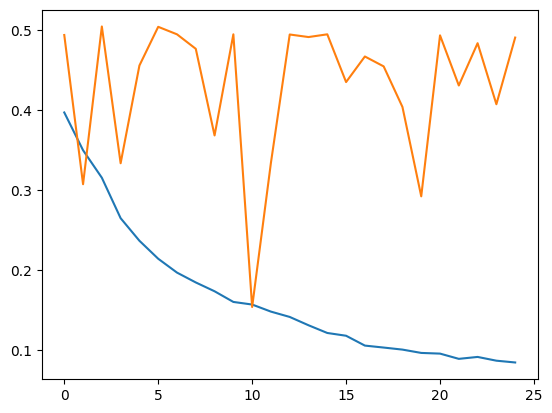

In [34]:
acc = model_with_sigmoid_activation_f_history.history['accuracy']
val_acc = model_with_sigmoid_activation_f_history.history['val_accuracy']
loss = model_with_sigmoid_activation_f_history.history['loss']
val_loss = model_with_sigmoid_activation_f_history.history['val_loss']

plt.plot(1 - np.array(acc))
plt.plot(1 - np.array(val_acc))

#### tanh

In [30]:
def make_model_with_tanh_activation_f(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape)
        
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("tanh")(x)
    
    previous_block_activation = x
    for size in [512, 1024, 2048]:
        x = layers.Activation("tanh")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("tanh")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        
        x = layers.add([x, residual])
        previous_block_activation = x
        
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("tanh")(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [31]:
model_with_tanh_activation_f = make_model_with_tanh_activation_f(input_shape=image_size + (3,), num_classes=2)
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")
]

model_with_tanh_activation_f.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_with_tanh_activation_f_history = model_with_tanh_activation_f.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds
)

Epoch 1/25


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:22 - loss: 0.7732 - accuracy: 0.5536

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:02 - loss: 0.7336 - accuracy: 0.5630

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.7087 - accuracy: 0.5765

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:05 - loss: 0.7075 - accuracy: 0.5753

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.7059 - accuracy: 0.5766

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:47 - loss: 0.7034 - accuracy: 0.5770

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:36 - loss: 0.7008 - accuracy: 0.5777

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.7010 - accuracy: 0.5778

528/586 [==========================>...] - ETA: 22s - loss: 0.6859 - accuracy: 0.5889

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.6817 - accuracy: 0.5934

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 264s 430ms/step - loss: 0.6817 - accuracy: 0.5934 - val_loss: 1.0959 - val_accuracy: 0.5019
Epoch 2/25
  2/586 [..............................] - ETA: 4:01 - loss: 0.5699 - accuracy: 0.6875 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:25 - loss: 0.6205 - accuracy: 0.6465

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.6151 - accuracy: 0.6620

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:19 - loss: 0.6173 - accuracy: 0.6669

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:06 - loss: 0.6169 - accuracy: 0.6680

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.6168 - accuracy: 0.6680

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:48 - loss: 0.6132 - accuracy: 0.6714

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.6116 - accuracy: 0.6727

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.6115 - accuracy: 0.6726

528/586 [==========================>...] - ETA: 23s - loss: 0.6025 - accuracy: 0.6790

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.5991 - accuracy: 0.6822

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 253s 430ms/step - loss: 0.5991 - accuracy: 0.6822 - val_loss: 0.6093 - val_accuracy: 0.6679
Epoch 3/25
  2/586 [..............................] - ETA: 4:19 - loss: 0.5766 - accuracy: 0.6250 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:24 - loss: 0.5664 - accuracy: 0.7099

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.5668 - accuracy: 0.7078

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.5634 - accuracy: 0.7127

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:05 - loss: 0.5658 - accuracy: 0.7097

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.5642 - accuracy: 0.7104

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:47 - loss: 0.5614 - accuracy: 0.7113

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.5606 - accuracy: 0.7116

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.5606 - accuracy: 0.7116

528/586 [==========================>...] - ETA: 23s - loss: 0.5585 - accuracy: 0.7163

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.5569 - accuracy: 0.7169

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 253s 430ms/step - loss: 0.5569 - accuracy: 0.7169 - val_loss: 0.5515 - val_accuracy: 0.7223
Epoch 4/25
  1/586 [..............................] - ETA: 13:12 - loss: 0.5654 - accuracy: 0.7188

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:25 - loss: 0.5418 - accuracy: 0.7302

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.5376 - accuracy: 0.7333

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.5350 - accuracy: 0.7373

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:05 - loss: 0.5367 - accuracy: 0.7363

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.5367 - accuracy: 0.7360

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:48 - loss: 0.5348 - accuracy: 0.7361

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.5333 - accuracy: 0.7358

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.5332 - accuracy: 0.7361

528/586 [==========================>...] - ETA: 23s - loss: 0.5276 - accuracy: 0.7404

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.5255 - accuracy: 0.7427

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 253s 430ms/step - loss: 0.5255 - accuracy: 0.7427 - val_loss: 0.5364 - val_accuracy: 0.7236
Epoch 5/25
  2/586 [..............................] - ETA: 4:51 - loss: 0.3352 - accuracy: 0.9062 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:25 - loss: 0.5115 - accuracy: 0.7631

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.5122 - accuracy: 0.7577

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.5123 - accuracy: 0.7534

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:06 - loss: 0.5119 - accuracy: 0.7546

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.5105 - accuracy: 0.7545

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:48 - loss: 0.5087 - accuracy: 0.7557

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.5065 - accuracy: 0.7580

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.5065 - accuracy: 0.7578

528/586 [==========================>...] - ETA: 23s - loss: 0.5025 - accuracy: 0.7575

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.5008 - accuracy: 0.7584

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



237/586 [===========>..................] - ETA: 2:18 - loss: 0.3453 - accuracy: 0.8502

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:05 - loss: 0.3453 - accuracy: 0.8519

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.3450 - accuracy: 0.8517

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:47 - loss: 0.3437 - accuracy: 0.8513

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.3444 - accuracy: 0.8516

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.3446 - accuracy: 0.8517

528/586 [==========================>...] - ETA: 23s - loss: 0.3404 - accuracy: 0.8523

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.3379 - accuracy: 0.8531

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 253s 429ms/step - loss: 0.3379 - accuracy: 0.8531 - val_loss: 1.0011 - val_accuracy: 0.5910
Epoch 13/25
  1/586 [..............................] - ETA: 12:34 - loss: 0.2278 - accuracy: 0.9062

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:25 - loss: 0.2984 - accuracy: 0.8754

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.3035 - accuracy: 0.8705

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.3135 - accuracy: 0.8680

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:05 - loss: 0.3120 - accuracy: 0.8683

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.3120 - accuracy: 0.8675

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:47 - loss: 0.3095 - accuracy: 0.8679

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.3098 - accuracy: 0.8683

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.3101 - accuracy: 0.8680

528/586 [==========================>...] - ETA: 22s - loss: 0.3070 - accuracy: 0.8696

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.3069 - accuracy: 0.8691

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 252s 429ms/step - loss: 0.3069 - accuracy: 0.8691 - val_loss: 0.6649 - val_accuracy: 0.7117
Epoch 14/25
  1/586 [..............................] - ETA: 12:25 - loss: 0.6509 - accuracy: 0.7812

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 76/586 [==>...........................] - ETA: 3:23 - loss: 0.2786 - accuracy: 0.8824

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


127/586 [=====>........................] - ETA: 3:02 - loss: 0.2780 - accuracy: 0.8836

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


239/586 [===========>..................] - ETA: 2:17 - loss: 0.2889 - accuracy: 0.8772

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


271/586 [============>.................] - ETA: 2:04 - loss: 0.2905 - accuracy: 0.8770

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


282/586 [=============>................] - ETA: 2:00 - loss: 0.2898 - accuracy: 0.8772

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


316/586 [===============>..............] - ETA: 1:47 - loss: 0.2862 - accuracy: 0.8795

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.2861 - accuracy: 0.8799

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


345/586 [================>.............] - ETA: 1:35 - loss: 0.2858 - accuracy: 0.8803

530/586 [==========================>...] - ETA: 22s - loss: 0.2848 - accuracy: 0.8808

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2802 - accuracy: 0.8826

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 252s 429ms/step - loss: 0.2802 - accuracy: 0.8826 - val_loss: 5.8111 - val_accuracy: 0.5049
Epoch 15/25
  2/586 [..............................] - ETA: 4:18 - loss: 0.3088 - accuracy: 0.8750 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:24 - loss: 0.2757 - accuracy: 0.8881

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.2697 - accuracy: 0.8882

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.2710 - accuracy: 0.8902

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:05 - loss: 0.2704 - accuracy: 0.8888

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.2706 - accuracy: 0.8891

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:47 - loss: 0.2689 - accuracy: 0.8892

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.2683 - accuracy: 0.8899

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.2684 - accuracy: 0.8898

528/586 [==========================>...] - ETA: 22s - loss: 0.2640 - accuracy: 0.8927

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2594 - accuracy: 0.8945

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 252s 429ms/step - loss: 0.2594 - accuracy: 0.8945 - val_loss: 0.3011 - val_accuracy: 0.8774
Epoch 16/25
  2/586 [..............................] - ETA: 4:17 - loss: 0.3077 - accuracy: 0.8750 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:24 - loss: 0.2232 - accuracy: 0.9033

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.2366 - accuracy: 0.9020

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.2353 - accuracy: 0.9031

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:05 - loss: 0.2371 - accuracy: 0.9024

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.2362 - accuracy: 0.9025

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:47 - loss: 0.2352 - accuracy: 0.9029

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.2327 - accuracy: 0.9040

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.2333 - accuracy: 0.9035

528/586 [==========================>...] - ETA: 22s - loss: 0.2340 - accuracy: 0.9036

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2310 - accuracy: 0.9040

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 252s 429ms/step - loss: 0.2310 - accuracy: 0.9040 - val_loss: 0.3443 - val_accuracy: 0.8531
Epoch 17/25
  1/586 [..............................] - ETA: 13:02 - loss: 0.1941 - accuracy: 0.8750

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:24 - loss: 0.2113 - accuracy: 0.9105

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.2158 - accuracy: 0.9120

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


166/586 [=======>......................] - ETA: 2:46 - loss: 0.2192 - accuracy: 0.9119

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



237/586 [===========>..................] - ETA: 2:18 - loss: 0.1633 - accuracy: 0.9351

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:06 - loss: 0.1670 - accuracy: 0.9332

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.1671 - accuracy: 0.9335

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:48 - loss: 0.1675 - accuracy: 0.9332

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.1646 - accuracy: 0.9340

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.1640 - accuracy: 0.9342

528/586 [==========================>...] - ETA: 23s - loss: 0.1573 - accuracy: 0.9370

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1562 - accuracy: 0.9373

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 253s 430ms/step - loss: 0.1562 - accuracy: 0.9373 - val_loss: 4.2863 - val_accuracy: 0.5060
Epoch 24/25
  2/586 [..............................] - ETA: 3:58 - loss: 0.2158 - accuracy: 0.9375 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:24 - loss: 0.1603 - accuracy: 0.9316

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.1534 - accuracy: 0.9317

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.1540 - accuracy: 0.9359

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:05 - loss: 0.1533 - accuracy: 0.9369

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.1533 - accuracy: 0.9371

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:47 - loss: 0.1520 - accuracy: 0.9373

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.1497 - accuracy: 0.9383

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.1493 - accuracy: 0.9386

528/586 [==========================>...] - ETA: 22s - loss: 0.1479 - accuracy: 0.9392

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1486 - accuracy: 0.9389

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 252s 429ms/step - loss: 0.1486 - accuracy: 0.9389 - val_loss: 2.9536 - val_accuracy: 0.5442
Epoch 25/25
  1/586 [..............................] - ETA: 13:43 - loss: 0.1821 - accuracy: 0.9062

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/586 [==>...........................] - ETA: 3:24 - loss: 0.1273 - accuracy: 0.9459

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


125/586 [=====>........................] - ETA: 3:03 - loss: 0.1332 - accuracy: 0.9433

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


237/586 [===========>..................] - ETA: 2:18 - loss: 0.1417 - accuracy: 0.9420

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/586 [============>.................] - ETA: 2:05 - loss: 0.1432 - accuracy: 0.9424

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/586 [=============>................] - ETA: 2:01 - loss: 0.1432 - accuracy: 0.9420

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


314/586 [===============>..............] - ETA: 1:47 - loss: 0.1420 - accuracy: 0.9425

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/586 [================>.............] - ETA: 1:37 - loss: 0.1416 - accuracy: 0.9424

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


343/586 [================>.............] - ETA: 1:36 - loss: 0.1412 - accuracy: 0.9426

528/586 [==========================>...] - ETA: 22s - loss: 0.1397 - accuracy: 0.9438

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1399 - accuracy: 0.9433

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 253s 429ms/step - loss: 0.1399 - accuracy: 0.9433 - val_loss: 2.3514 - val_accuracy: 0.5848


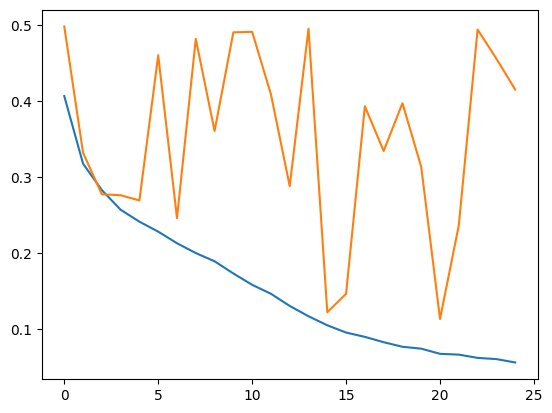

In [35]:
acc = model_with_tanh_activation_f_history.history['accuracy']
val_acc = model_with_tanh_activation_f_history.history['val_accuracy']
loss = model_with_tanh_activation_f_history.history['loss']
val_loss = model_with_tanh_activation_f_history.history['val_loss']

plt.plot(1 - np.array(acc))
plt.plot(1 - np.array(val_acc))

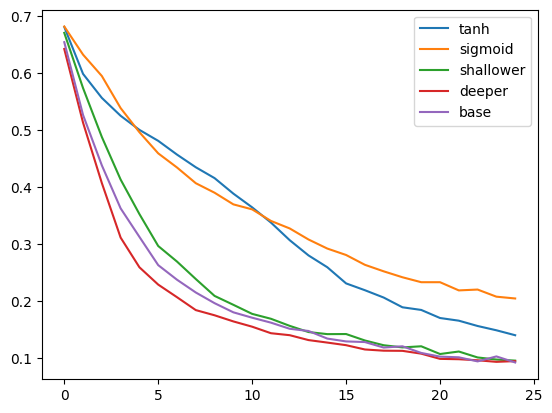

In [43]:
loss_tanh = model_with_tanh_activation_f_history.history['loss']
loss_sigmoid = model_with_sigmoid_activation_f_history.history['loss']
loss_shallower = shallower_model_history.history['loss']
loss_base = history.history['loss']
loss_deeper = deeper_model_history.history['loss']

plt.plot(np.array(loss_tanh), label="tanh")
plt.plot(np.array(loss_sigmoid), label="sigmoid")
plt.plot(np.array(loss_shallower), label="shallower")
plt.plot(np.array(loss_deeper), label="deeper")
plt.plot(np.array(loss_base), label="base")
plt.legend()